In [1]:
import os
import torch
import numpy as np
import pandas as pd

from sklearn import preprocessing
from torch_geometric.data import Data
from utils import ROOT_DIR, NEURON_LABELS
from visualize._utils import draw_connectome


CUDA device found.
	 GPU: NVIDIA A100 80GB PCIe


# Process messy CSV

In [2]:
file = "white_1986_jse"

processed_csv = ""

with open("../data/raw/" + file + ".csv", "r") as f:
    for line in f:
        processed_csv += line.replace("\t", ",")

with open("../data/raw/" + file + "_processed.csv", "w") as f:
    f.write(processed_csv)

# OpenWorm

Attributes: 
 <bound method BaseData.keys of Data(
  x=[300, 1024],
  edge_index=[2, 3119],
  edge_attr=[3119, 2],
  y=[300],
  pos={
    0=[3],
    1=[3],
    2=[3],
    3=[3],
    4=[3],
    5=[3],
    6=[3],
    7=[3],
    8=[3],
    9=[3],
    10=[3],
    11=[3],
    12=[3],
    13=[3],
    14=[3],
    15=[3],
    16=[3],
    17=[3],
    18=[3],
    19=[3],
    20=[3],
    21=[3],
    22=[3],
    23=[3],
    24=[3],
    25=[3],
    26=[3],
    27=[3],
    28=[3],
    29=[3],
    30=[3],
    31=[3],
    32=[3],
    33=[3],
    34=[3],
    35=[3],
    36=[3],
    37=[3],
    38=[3],
    39=[3],
    40=[3],
    41=[3],
    42=[3],
    43=[3],
    44=[3],
    45=[3],
    46=[3],
    47=[3],
    48=[3],
    49=[3],
    50=[3],
    51=[3],
    52=[3],
    53=[3],
    54=[3],
    55=[3],
    56=[3],
    57=[3],
    58=[3],
    59=[3],
    60=[3],
    61=[3],
    62=[3],
    63=[3],
    64=[3],
    65=[3],
    66=[3],
    67=[3],
    68=[3],
    69=[3],
    70=[3],
    71=[3],
    72=[3],


ValueError: too many values to unpack (expected 2)

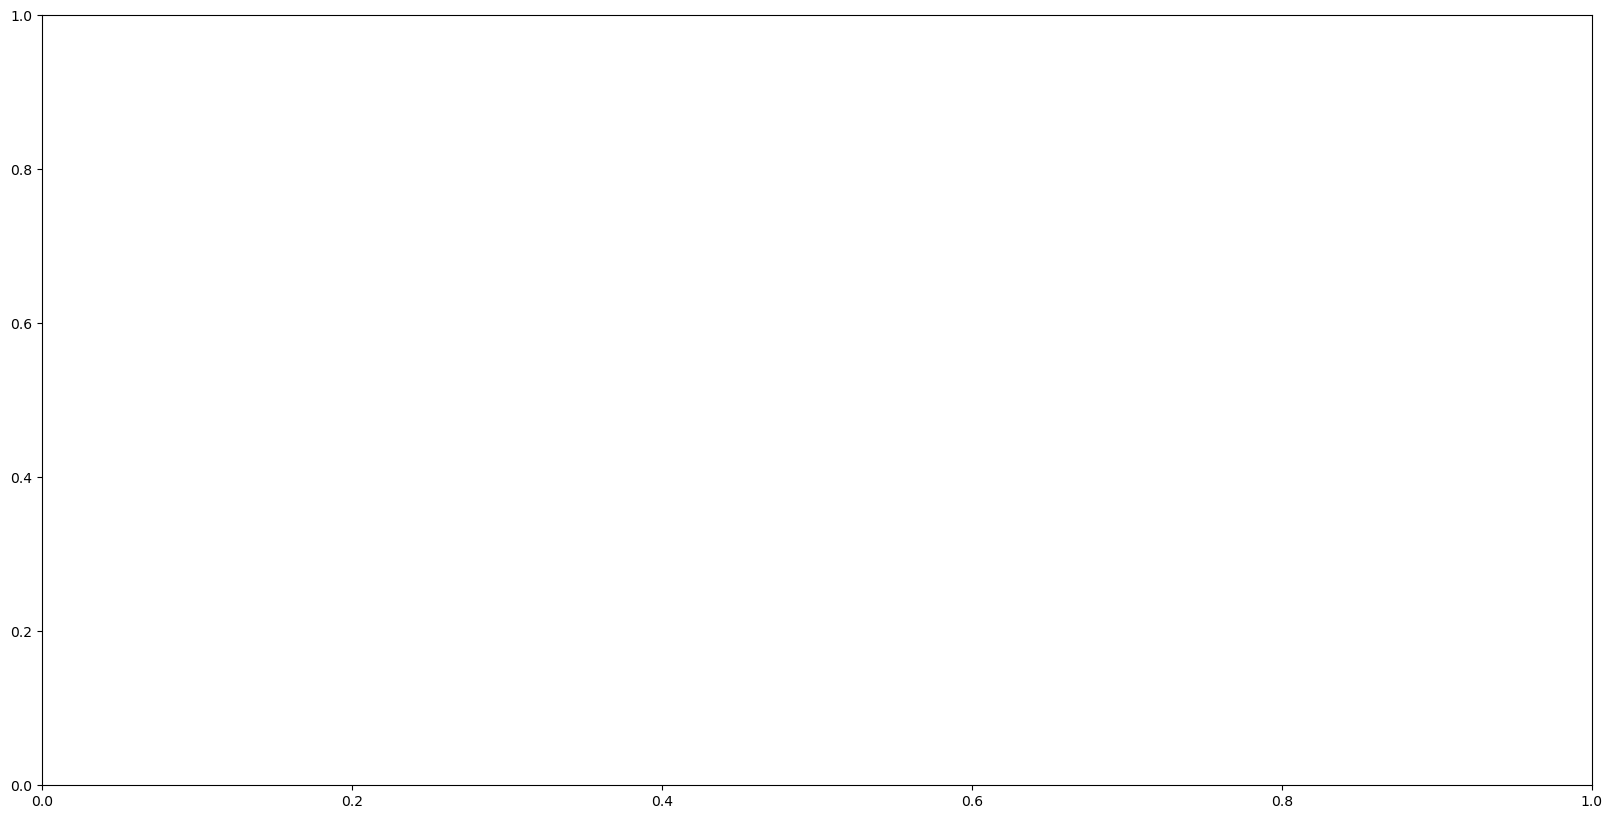

In [3]:
df = pd.read_csv("../data/raw/OpenWormConnectome.csv")
        
origin = []
target = []
edges = []

edge_attr = []

# CANL, CANR not considered neurons in Cook et al (still include in matrix - data will be zero/null when passed to model)

for i in range(len(df)):
    neuron1 = df.loc[i, "Origin"]
    neuron2 = df.loc[i, "Target"]
    
    origin += [neuron1]
    target += [neuron2]
    
    type = df.loc[i, "Type"]
    num_connections = df.loc[i, "Number of Connections"]
    
    if [neuron1, neuron2] not in edges:
        edges += [[neuron1, neuron2]]
        if type == "GapJunction":
            edge_attr += [[num_connections, 0]]
        else:
            edge_attr += [[0, num_connections]]
    else:
        if type == "GapJunction":
            edge_attr[-1][0] = num_connections
        else:
            edge_attr[-1][-1] = num_connections

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "open_worm_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)

In [11]:
graph.edge_attr

tensor([[1, 0],
        [1, 0],
        [0, 1],
        ...,
        [0, 2],
        [6, 3],
        [1, 1]])

# Witvliet 2020 7

Attributes: 
 <bound method BaseData.keys of Data(
  x=[302, 1024],
  edge_index=[2, 2168],
  edge_attr=[2168, 2],
  y=[302],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2],
    7=[2],
    8=[2],
    9=[2],
    10=[2],
    11=[2],
    12=[2],
    13=[2],
    14=[2],
    15=[2],
    16=[2],
    17=[2],
    18=[2],
    19=[2],
    20=[2],
    21=[2],
    22=[2],
    23=[2],
    24=[2],
    25=[2],
    26=[2],
    27=[2],
    28=[2],
    29=[2],
    30=[2],
    31=[2],
    32=[2],
    33=[2],
    34=[2],
    35=[2],
    36=[2],
    37=[2],
    38=[2],
    39=[2],
    40=[2],
    41=[2],
    42=[2],
    43=[2],
    44=[2],
    45=[2],
    46=[2],
    47=[2],
    48=[2],
    49=[2],
    50=[2],
    51=[2],
    52=[2],
    53=[2],
    54=[2],
    55=[2],
    56=[2],
    57=[2],
    58=[2],
    59=[2],
    60=[2],
    61=[2],
    62=[2],
    63=[2],
    64=[2],
    65=[2],
    66=[2],
    67=[2],
    68=[2],
    69=[2],
    70=[2],
    71=[2],
    72=[2],


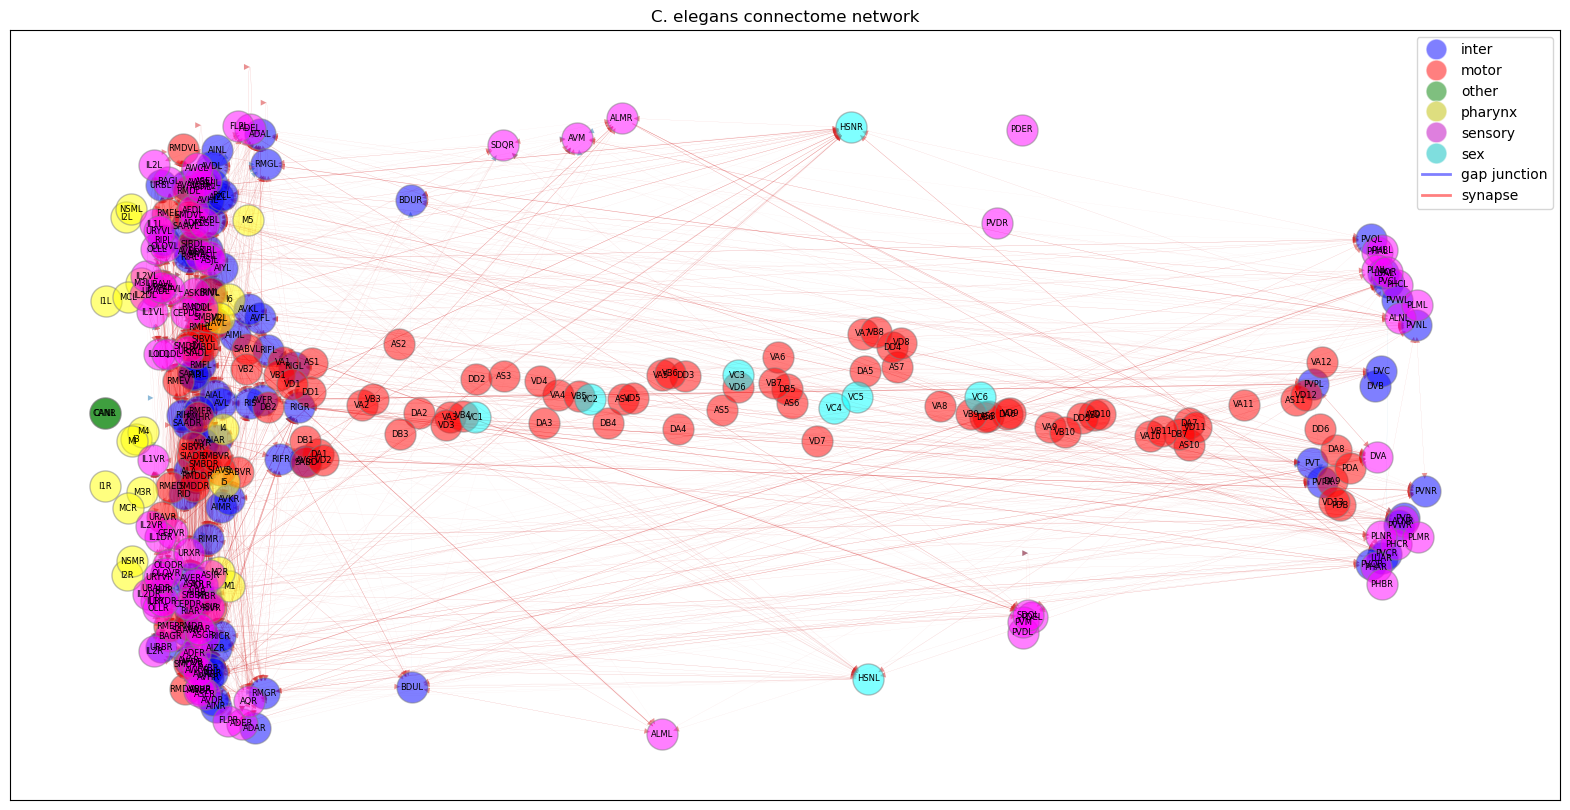

In [12]:
df = pd.read_csv("../data/raw/witvliet_2020_7_processed.csv")
origin = []
target = []
edges = []

NEURON_LABELS = [ # TODO: Cite source of this list.
            "ADAL", "ADAR", "ADEL", "ADER", "ADFL", "ADFR", "ADLL", "ADLR", "AFDL", "AFDR",
            "AIAL", "AIAR", "AIBL", "AIBR", "AIML", "AIMR", "AINL", "AINR", "AIYL", "AIYR",
            "AIZL", "AIZR", "ALA", "ALML", "ALMR", "ALNL", "ALNR", "AQR", "AS1", "AS10",
            "AS11", "AS2", "AS3", "AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "ASEL", "ASER",
            "ASGL", "ASGR", "ASHL", "ASHR", "ASIL", "ASIR", "ASJL", "ASJR", "ASKL", "ASKR",
            "AUAL", "AUAR", "AVAL", "AVAR", "AVBL", "AVBR", "AVDL", "AVDR", "AVEL", "AVER",
            "AVFL", "AVFR", "AVG", "AVHL", "AVHR", "AVJL", "AVJR", "AVKL", "AVKR", "AVL",
            "AVM", "AWAL", "AWAR", "AWBL", "AWBR", "AWCL", "AWCR", "BAGL", "BAGR", "BDUL",
            "BDUR", "CANL", "CANR", "CEPDL", "CEPDR", "CEPVL", "CEPVR", "DA1", "DA2", "DA3",
            "DA4", "DA5", "DA6", "DA7", "DA8", "DA9", "DB1", "DB2", "DB3", "DB4", "DB5",
            "DB6", "DB7", "DD1", "DD2", "DD3", "DD4", "DD5", "DD6", "DVA", "DVB", "DVC",
            "FLPL", "FLPR", "HSNL", "HSNR", "I1L", "I1R", "I2L", "I2R", "I3", "I4", "I5",
            "I6", "IL1DL", "IL1DR", "IL1L", "IL1R", "IL1VL", "IL1VR", "IL2DL", "IL2DR", "IL2L",
            "IL2R", "IL2VL", "IL2VR", "LUAL", "LUAR", "M1", "M2L", "M2R", "M3L", "M3R", "M4",
            "M5", "MCL", "MCR", "MI", "NSML", "NSMR", "OLLL", "OLLR", "OLQDL", "OLQDR",
            "OLQVL", "OLQVR", "PDA", "PDB", "PDEL", "PDER", "PHAL", "PHAR", "PHBL", "PHBR",
            "PHCL", "PHCR", "PLML", "PLMR", "PLNL", "PLNR", "PQR", "PVCL", "PVCR", "PVDL",
            "PVDR", "PVM", "PVNL", "PVNR", "PVPL", "PVPR", "PVQL", "PVQR", "PVR", "PVT",
            "PVWL", "PVWR", "RIAL", "RIAR", "RIBL", "RIBR", "RICL", "RICR", "RID", "RIFL",
            "RIFR", "RIGL", "RIGR", "RIH", "RIML", "RIMR", "RIPL", "RIPR", "RIR", "RIS",
            "RIVL", "RIVR", "RMDDL", "RMDDR", "RMDL", "RMDR", "RMDVL", "RMDVR", "RMED",
            "RMEL", "RMER", "RMEV", "RMFL", "RMFR", "RMGL", "RMGR", "RMHL", "RMHR", "SAADL",
            "SAADR", "SAAVL", "SAAVR", "SABD", "SABVL", "SABVR", "SDQL", "SDQR", "SIADL",
            "SIADR", "SIAVL", "SIAVR", "SIBDL", "SIBDR", "SIBVL", "SIBVR", "SMBDL", "SMBDR",
            "SMBVL", "SMBVR", "SMDDL", "SMDDR", "SMDVL", "SMDVR", "URADL", "URADR", "URAVL",
            "URAVR", "URBL", "URBR", "URXL", "URXR", "URYDL", "URYDR", "URYVL", "URYVR",
            "VA1", "VA10", "VA11", "VA12", "VA2", "VA3", "VA4", "VA5", "VA6", "VA7", "VA8",
            "VA9", "VB1", "VB10", "VB11", "VB2", "VB3", "VB4", "VB5", "VB6", "VB7", "VB8",
            "VB9", "VC1", "VC2", "VC3", "VC4", "VC5", "VC6", "VD1", "VD10", "VD11", "VD12",
            "VD13", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9"
        ]

edge_attr = []

for i in range(len(df)):
    neuron1 = df.loc[i, "pre"]
    neuron2 = df.loc[i, "post"]
    
    if neuron1 in NEURON_LABELS and neuron2 in NEURON_LABELS:
        origin += [neuron1]
        target += [neuron2]
        
        type = df.loc[i, "type"]
        num_connections = df.loc[i, "synapses"]
        
        if [neuron1, neuron2] not in edges:
            edges += [[neuron1, neuron2]]
            if type == "electrical":
                edge_attr += [[num_connections, 0]]
            else:
                edge_attr += [[0, num_connections]]
        else:
            if type == "electrical":
                edge_attr[-1][0] = num_connections
            else:
                edge_attr[-1][-1] = num_connections

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "witvliet_2020_7_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)

# Witvliet 2020 8

Attributes: 
 <bound method BaseData.keys of Data(
  x=[302, 1024],
  edge_index=[2, 2157],
  edge_attr=[2157, 2],
  y=[302],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2],
    7=[2],
    8=[2],
    9=[2],
    10=[2],
    11=[2],
    12=[2],
    13=[2],
    14=[2],
    15=[2],
    16=[2],
    17=[2],
    18=[2],
    19=[2],
    20=[2],
    21=[2],
    22=[2],
    23=[2],
    24=[2],
    25=[2],
    26=[2],
    27=[2],
    28=[2],
    29=[2],
    30=[2],
    31=[2],
    32=[2],
    33=[2],
    34=[2],
    35=[2],
    36=[2],
    37=[2],
    38=[2],
    39=[2],
    40=[2],
    41=[2],
    42=[2],
    43=[2],
    44=[2],
    45=[2],
    46=[2],
    47=[2],
    48=[2],
    49=[2],
    50=[2],
    51=[2],
    52=[2],
    53=[2],
    54=[2],
    55=[2],
    56=[2],
    57=[2],
    58=[2],
    59=[2],
    60=[2],
    61=[2],
    62=[2],
    63=[2],
    64=[2],
    65=[2],
    66=[2],
    67=[2],
    68=[2],
    69=[2],
    70=[2],
    71=[2],
    72=[2],


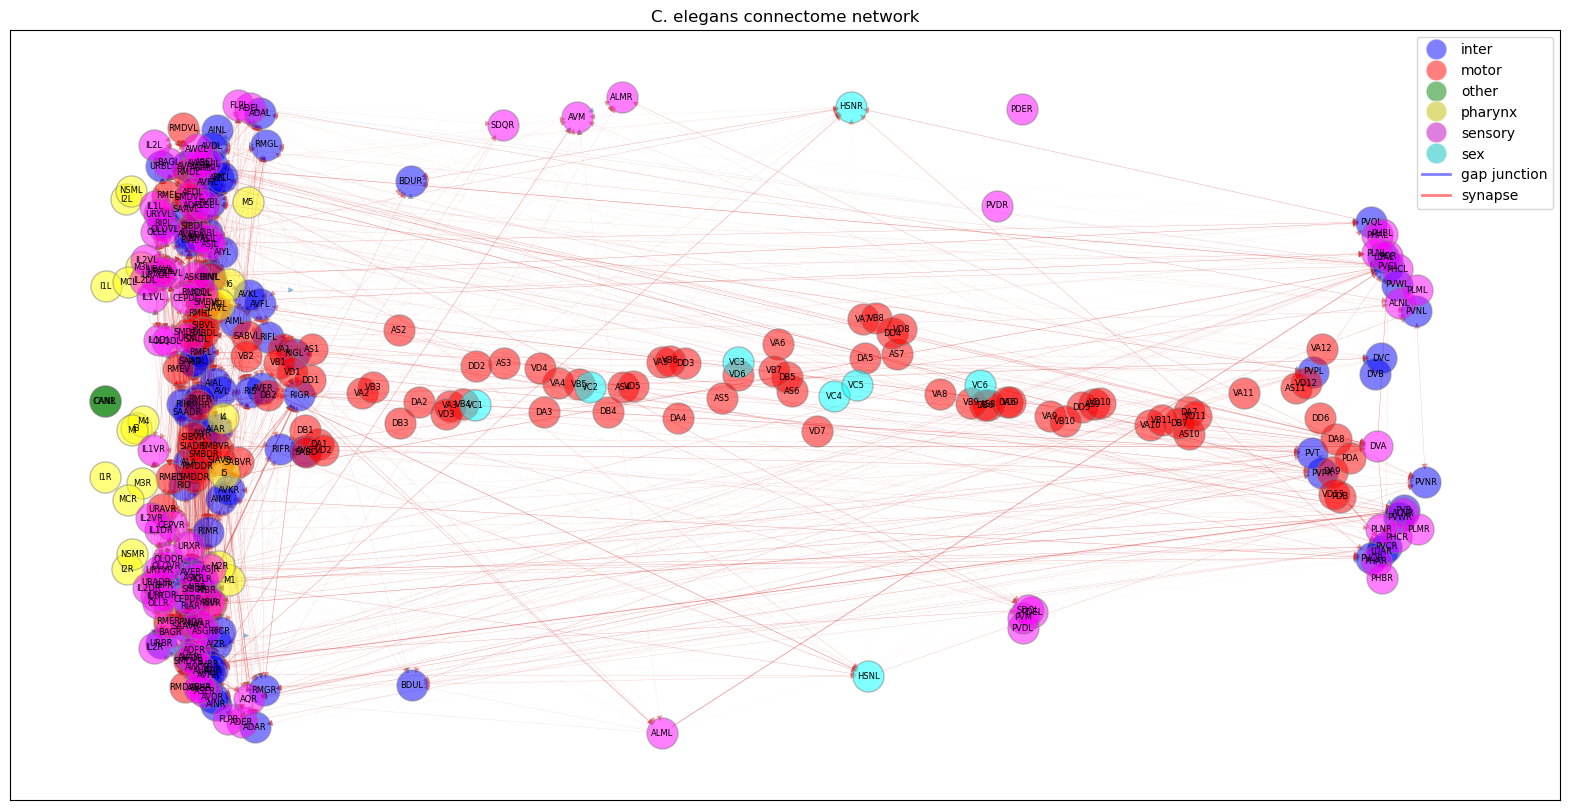

In [14]:
df = pd.read_csv("../data/raw/witvliet_2020_8_processed.csv")
origin = []
target = []
edges = []

NEURON_LABELS = [ # TODO: Cite source of this list.
            "ADAL", "ADAR", "ADEL", "ADER", "ADFL", "ADFR", "ADLL", "ADLR", "AFDL", "AFDR",
            "AIAL", "AIAR", "AIBL", "AIBR", "AIML", "AIMR", "AINL", "AINR", "AIYL", "AIYR",
            "AIZL", "AIZR", "ALA", "ALML", "ALMR", "ALNL", "ALNR", "AQR", "AS1", "AS10",
            "AS11", "AS2", "AS3", "AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "ASEL", "ASER",
            "ASGL", "ASGR", "ASHL", "ASHR", "ASIL", "ASIR", "ASJL", "ASJR", "ASKL", "ASKR",
            "AUAL", "AUAR", "AVAL", "AVAR", "AVBL", "AVBR", "AVDL", "AVDR", "AVEL", "AVER",
            "AVFL", "AVFR", "AVG", "AVHL", "AVHR", "AVJL", "AVJR", "AVKL", "AVKR", "AVL",
            "AVM", "AWAL", "AWAR", "AWBL", "AWBR", "AWCL", "AWCR", "BAGL", "BAGR", "BDUL",
            "BDUR", "CANL", "CANR", "CEPDL", "CEPDR", "CEPVL", "CEPVR", "DA1", "DA2", "DA3",
            "DA4", "DA5", "DA6", "DA7", "DA8", "DA9", "DB1", "DB2", "DB3", "DB4", "DB5",
            "DB6", "DB7", "DD1", "DD2", "DD3", "DD4", "DD5", "DD6", "DVA", "DVB", "DVC",
            "FLPL", "FLPR", "HSNL", "HSNR", "I1L", "I1R", "I2L", "I2R", "I3", "I4", "I5",
            "I6", "IL1DL", "IL1DR", "IL1L", "IL1R", "IL1VL", "IL1VR", "IL2DL", "IL2DR", "IL2L",
            "IL2R", "IL2VL", "IL2VR", "LUAL", "LUAR", "M1", "M2L", "M2R", "M3L", "M3R", "M4",
            "M5", "MCL", "MCR", "MI", "NSML", "NSMR", "OLLL", "OLLR", "OLQDL", "OLQDR",
            "OLQVL", "OLQVR", "PDA", "PDB", "PDEL", "PDER", "PHAL", "PHAR", "PHBL", "PHBR",
            "PHCL", "PHCR", "PLML", "PLMR", "PLNL", "PLNR", "PQR", "PVCL", "PVCR", "PVDL",
            "PVDR", "PVM", "PVNL", "PVNR", "PVPL", "PVPR", "PVQL", "PVQR", "PVR", "PVT",
            "PVWL", "PVWR", "RIAL", "RIAR", "RIBL", "RIBR", "RICL", "RICR", "RID", "RIFL",
            "RIFR", "RIGL", "RIGR", "RIH", "RIML", "RIMR", "RIPL", "RIPR", "RIR", "RIS",
            "RIVL", "RIVR", "RMDDL", "RMDDR", "RMDL", "RMDR", "RMDVL", "RMDVR", "RMED",
            "RMEL", "RMER", "RMEV", "RMFL", "RMFR", "RMGL", "RMGR", "RMHL", "RMHR", "SAADL",
            "SAADR", "SAAVL", "SAAVR", "SABD", "SABVL", "SABVR", "SDQL", "SDQR", "SIADL",
            "SIADR", "SIAVL", "SIAVR", "SIBDL", "SIBDR", "SIBVL", "SIBVR", "SMBDL", "SMBDR",
            "SMBVL", "SMBVR", "SMDDL", "SMDDR", "SMDVL", "SMDVR", "URADL", "URADR", "URAVL",
            "URAVR", "URBL", "URBR", "URXL", "URXR", "URYDL", "URYDR", "URYVL", "URYVR",
            "VA1", "VA10", "VA11", "VA12", "VA2", "VA3", "VA4", "VA5", "VA6", "VA7", "VA8",
            "VA9", "VB1", "VB10", "VB11", "VB2", "VB3", "VB4", "VB5", "VB6", "VB7", "VB8",
            "VB9", "VC1", "VC2", "VC3", "VC4", "VC5", "VC6", "VD1", "VD10", "VD11", "VD12",
            "VD13", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9"
        ]

edge_attr = []

for i in range(len(df)):
    neuron1 = df.loc[i, "pre"]
    neuron2 = df.loc[i, "post"]
    
    if neuron1 in NEURON_LABELS and neuron2 in NEURON_LABELS:
        origin += [neuron1]
        target += [neuron2]
        
        type = df.loc[i, "type"]
        num_connections = df.loc[i, "synapses"]
        
        if [neuron1, neuron2] not in edges:
            edges += [[neuron1, neuron2]]
            if type == "electrical":
                edge_attr += [[num_connections, 0]]
            else:
                edge_attr += [[0, num_connections]]
        else:
            if type == "electrical":
                edge_attr[-1][0] = num_connections
            else:
                edge_attr[-1][-1] = num_connections

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "witvliet_2007_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)

# Cook 2019

In [3]:
df = pd.read_excel("../data/raw/Cook2019.xlsx", sheet_name="hermaphrodite chemical")
df

Unnamed: 0 Unnamed: 1 Unnamed: 2 PHARYNX Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0          NaN        NaN        NaN     NaN        NaN        NaN        NaN   
1          NaN        NaN        NaN     I1L        I1R        I2L        I2R   
2      PHARYNX        NaN        I1L     NaN        NaN         10        NaN   
3          NaN        NaN        I1R     NaN        NaN        NaN          6   
4          NaN        NaN        I2L       2        NaN        NaN          3   
..         ...        ...        ...     ...        ...        ...        ...   
298        NaN        NaN       VC03     NaN        NaN        NaN        NaN   
299        NaN        NaN       VC04     NaN        NaN        NaN        NaN   
300        NaN        NaN       VC05     NaN        NaN        NaN        NaN   
301        NaN        NaN       VC06     NaN        NaN        NaN        NaN   
302        NaN        NaN        NaN     I1L        I1R        I2L        I2R   

    Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 448 Unnamed: 449  \
0          NaN        NaN        NaN  ...          NaN          NaN   
1           I3         I4         I5  ...         VC06        vm2AL   
2            3        NaN          2  ...          NaN          NaN   
3            1        NaN          2  ...          NaN          NaN   
4          NaN         13          2  ...          NaN          NaN   
..         ...        ...        ...  ...          ...          ...   
298        NaN        NaN        NaN  ...          NaN          NaN   
299        NaN        NaN        NaN  ...          NaN            2   
300        NaN        NaN        NaN  ...          NaN            2   
301        NaN        NaN        NaN  ...          NaN          NaN   
302         I3         I4         I5  ...         VC06        vm2aL   

    Unnamed: 450 Unnamed: 451 Unnamed: 452 Unnamed: 453 Unnamed: 454  \
0            NaN          NaN          NaN          NaN          NaN   
1          vm2AR        vm1AL        vm1AR        vm1PL        vm1PR   
2            NaN          NaN          NaN          NaN          NaN   
3            NaN          NaN          NaN          NaN          NaN   
4            NaN          NaN          NaN          NaN          NaN   
..           ...          ...          ...          ...          ...   
298          NaN          NaN          NaN          NaN          NaN   
299            3          NaN          NaN          NaN          NaN   
300            2          NaN          NaN          NaN          NaN   
301          NaN          NaN          NaN          NaN          NaN   
302        vm2aR          NaN          NaN          NaN          NaN   

    Unnamed: 455 Unnamed: 456 Unnamed: 457  
0            NaN          NaN          NaN  
1          vm2PL        vm2PR          NaN  
2            NaN          NaN          I1L  
3            NaN          NaN          I1R  
4            NaN          NaN          I2L  
..           ...          ...          ...  
298          NaN          NaN         VC03  
299            2            2         VC04  
300            3            2         VC05  
301          NaN          NaN         VC06  
302        vm2pL        vm2pR          NaN  

[303 rows x 458 columns]

Attributes: 
 <bound method BaseData.keys of Data(
  x=[302, 1024],
  edge_index=[2, 3515],
  edge_attr=[3515, 2],
  y=[302],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2],
    7=[2],
    8=[2],
    9=[2],
    10=[2],
    11=[2],
    12=[2],
    13=[2],
    14=[2],
    15=[2],
    16=[2],
    17=[2],
    18=[2],
    19=[2],
    20=[2],
    21=[2],
    22=[2],
    23=[2],
    24=[2],
    25=[2],
    26=[2],
    27=[2],
    28=[2],
    29=[2],
    30=[2],
    31=[2],
    32=[2],
    33=[2],
    34=[2],
    35=[2],
    36=[2],
    37=[2],
    38=[2],
    39=[2],
    40=[2],
    41=[2],
    42=[2],
    43=[2],
    44=[2],
    45=[2],
    46=[2],
    47=[2],
    48=[2],
    49=[2],
    50=[2],
    51=[2],
    52=[2],
    53=[2],
    54=[2],
    55=[2],
    56=[2],
    57=[2],
    58=[2],
    59=[2],
    60=[2],
    61=[2],
    62=[2],
    63=[2],
    64=[2],
    65=[2],
    66=[2],
    67=[2],
    68=[2],
    69=[2],
    70=[2],
    71=[2],
    72=[2],


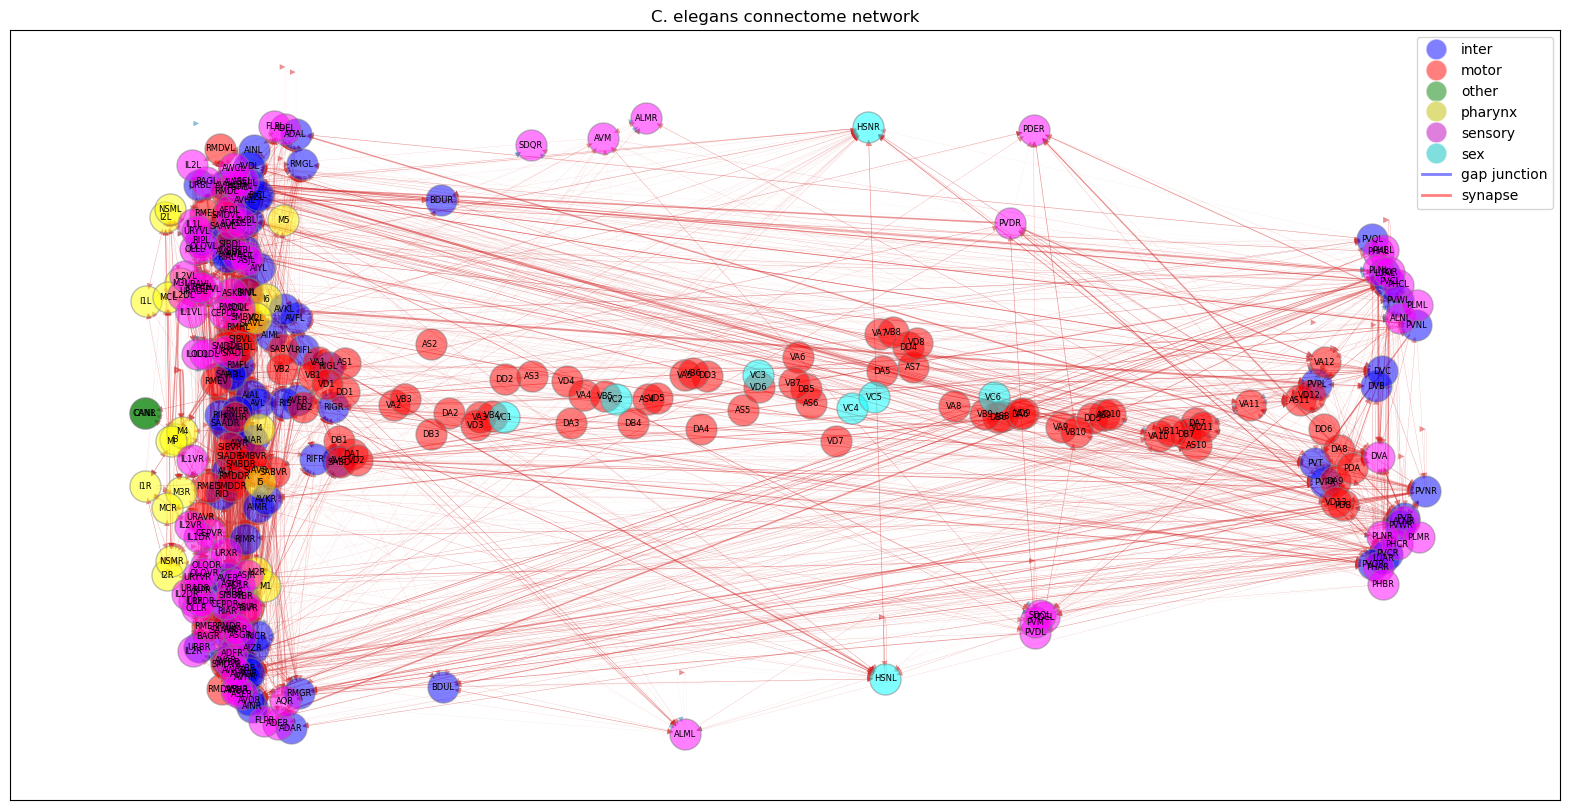

In [7]:
edges = []
edge_attr = []

# chemical synapse processing
df = pd.read_excel("../data/raw/Cook2019.xlsx", sheet_name="hermaphrodite chemical")

for i, line in enumerate(df):
    if i > 2:
        col_data = df.iloc[:-1, i]
        for j, weight in enumerate(col_data):
            if j > 1 and not pd.isna(df.iloc[j, i]):
                post = df.iloc[1, i]
                pre = df.iloc[j, 2]
                if pre in NEURON_LABELS and post in NEURON_LABELS:
                    edges += [[pre, post]]
                    edge_attr += [[0, df.iloc[j, i]]]

# gap junction processing
df = pd.read_excel("../data/raw/Cook2019.xlsx", sheet_name="hermaphrodite gap jn asymmetric")

for i, line in enumerate(df):
    if i > 2:
        col_data = df.iloc[:-1, i]
        for j, weight in enumerate(col_data):
            if j > 1 and not pd.isna(df.iloc[j, i]):
                post = df.iloc[1, i]
                pre = df.iloc[j, 2]
                if pre in NEURON_LABELS and post in NEURON_LABELS:
                    if [pre, post] in edges:
                        edge_idx = edges.index([pre, post])
                        edge_attr[edge_idx][0] = df.iloc[j, i]
                    else:
                        edges += [[pre, post]]
                        edge_attr += [[df.iloc[j, i], 0]]

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "witvliet_2007_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)

# White 1986 whole

Attributes: 
 <bound method BaseData.keys of Data(
  x=[302, 1024],
  edge_index=[2, 2692],
  edge_attr=[2692, 2],
  y=[302],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2],
    7=[2],
    8=[2],
    9=[2],
    10=[2],
    11=[2],
    12=[2],
    13=[2],
    14=[2],
    15=[2],
    16=[2],
    17=[2],
    18=[2],
    19=[2],
    20=[2],
    21=[2],
    22=[2],
    23=[2],
    24=[2],
    25=[2],
    26=[2],
    27=[2],
    28=[2],
    29=[2],
    30=[2],
    31=[2],
    32=[2],
    33=[2],
    34=[2],
    35=[2],
    36=[2],
    37=[2],
    38=[2],
    39=[2],
    40=[2],
    41=[2],
    42=[2],
    43=[2],
    44=[2],
    45=[2],
    46=[2],
    47=[2],
    48=[2],
    49=[2],
    50=[2],
    51=[2],
    52=[2],
    53=[2],
    54=[2],
    55=[2],
    56=[2],
    57=[2],
    58=[2],
    59=[2],
    60=[2],
    61=[2],
    62=[2],
    63=[2],
    64=[2],
    65=[2],
    66=[2],
    67=[2],
    68=[2],
    69=[2],
    70=[2],
    71=[2],
    72=[2],


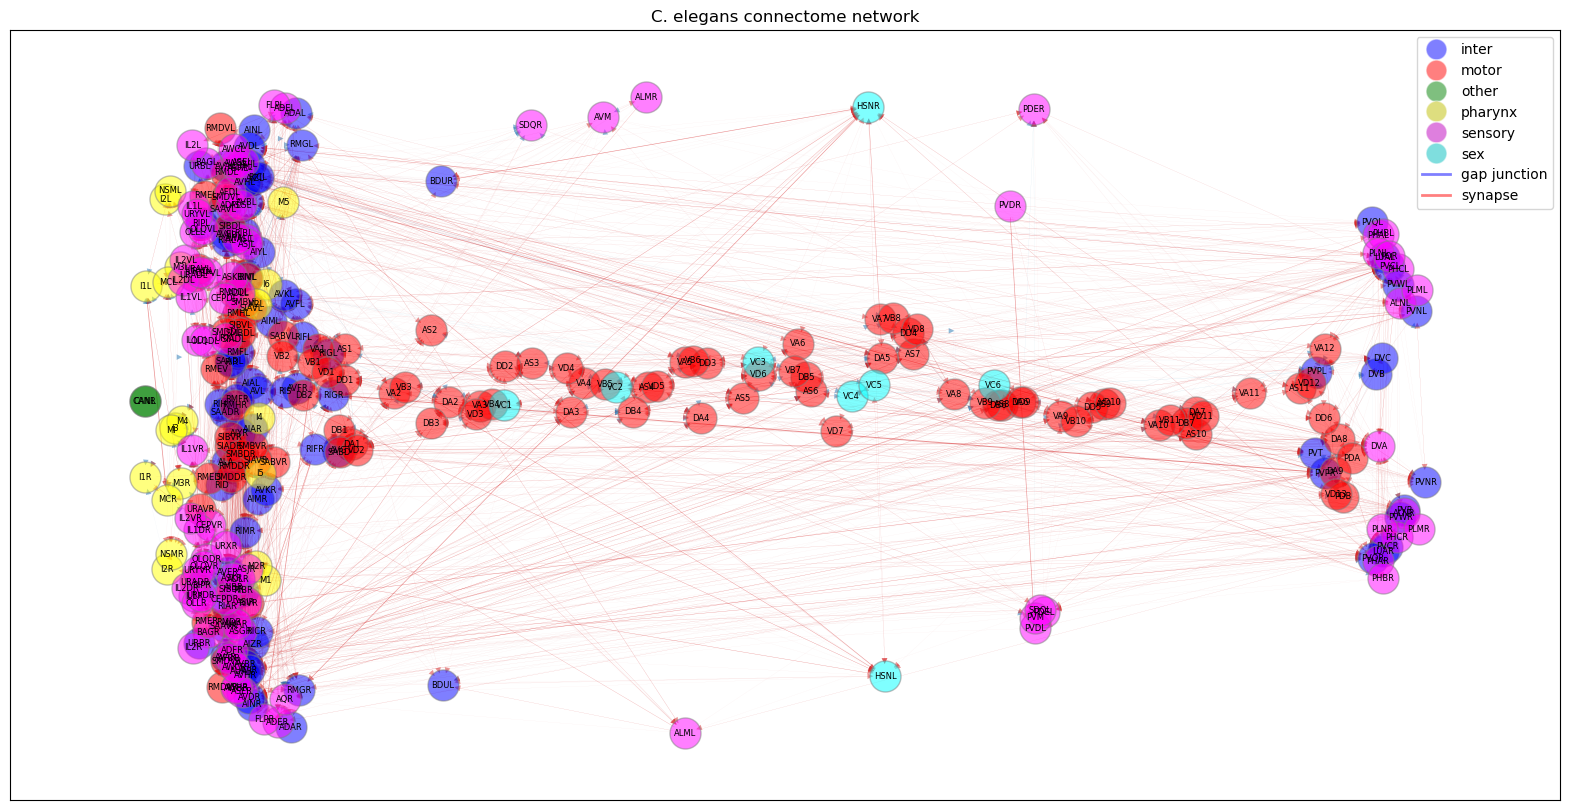

In [8]:
df = pd.read_csv("../data/raw/white_1986_whole_processed.csv")
origin = []
target = []
edges = []

NEURON_LABELS = [ # TODO: Cite source of this list.
            "ADAL", "ADAR", "ADEL", "ADER", "ADFL", "ADFR", "ADLL", "ADLR", "AFDL", "AFDR",
            "AIAL", "AIAR", "AIBL", "AIBR", "AIML", "AIMR", "AINL", "AINR", "AIYL", "AIYR",
            "AIZL", "AIZR", "ALA", "ALML", "ALMR", "ALNL", "ALNR", "AQR", "AS1", "AS10",
            "AS11", "AS2", "AS3", "AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "ASEL", "ASER",
            "ASGL", "ASGR", "ASHL", "ASHR", "ASIL", "ASIR", "ASJL", "ASJR", "ASKL", "ASKR",
            "AUAL", "AUAR", "AVAL", "AVAR", "AVBL", "AVBR", "AVDL", "AVDR", "AVEL", "AVER",
            "AVFL", "AVFR", "AVG", "AVHL", "AVHR", "AVJL", "AVJR", "AVKL", "AVKR", "AVL",
            "AVM", "AWAL", "AWAR", "AWBL", "AWBR", "AWCL", "AWCR", "BAGL", "BAGR", "BDUL",
            "BDUR", "CANL", "CANR", "CEPDL", "CEPDR", "CEPVL", "CEPVR", "DA1", "DA2", "DA3",
            "DA4", "DA5", "DA6", "DA7", "DA8", "DA9", "DB1", "DB2", "DB3", "DB4", "DB5",
            "DB6", "DB7", "DD1", "DD2", "DD3", "DD4", "DD5", "DD6", "DVA", "DVB", "DVC",
            "FLPL", "FLPR", "HSNL", "HSNR", "I1L", "I1R", "I2L", "I2R", "I3", "I4", "I5",
            "I6", "IL1DL", "IL1DR", "IL1L", "IL1R", "IL1VL", "IL1VR", "IL2DL", "IL2DR", "IL2L",
            "IL2R", "IL2VL", "IL2VR", "LUAL", "LUAR", "M1", "M2L", "M2R", "M3L", "M3R", "M4",
            "M5", "MCL", "MCR", "MI", "NSML", "NSMR", "OLLL", "OLLR", "OLQDL", "OLQDR",
            "OLQVL", "OLQVR", "PDA", "PDB", "PDEL", "PDER", "PHAL", "PHAR", "PHBL", "PHBR",
            "PHCL", "PHCR", "PLML", "PLMR", "PLNL", "PLNR", "PQR", "PVCL", "PVCR", "PVDL",
            "PVDR", "PVM", "PVNL", "PVNR", "PVPL", "PVPR", "PVQL", "PVQR", "PVR", "PVT",
            "PVWL", "PVWR", "RIAL", "RIAR", "RIBL", "RIBR", "RICL", "RICR", "RID", "RIFL",
            "RIFR", "RIGL", "RIGR", "RIH", "RIML", "RIMR", "RIPL", "RIPR", "RIR", "RIS",
            "RIVL", "RIVR", "RMDDL", "RMDDR", "RMDL", "RMDR", "RMDVL", "RMDVR", "RMED",
            "RMEL", "RMER", "RMEV", "RMFL", "RMFR", "RMGL", "RMGR", "RMHL", "RMHR", "SAADL",
            "SAADR", "SAAVL", "SAAVR", "SABD", "SABVL", "SABVR", "SDQL", "SDQR", "SIADL",
            "SIADR", "SIAVL", "SIAVR", "SIBDL", "SIBDR", "SIBVL", "SIBVR", "SMBDL", "SMBDR",
            "SMBVL", "SMBVR", "SMDDL", "SMDDR", "SMDVL", "SMDVR", "URADL", "URADR", "URAVL",
            "URAVR", "URBL", "URBR", "URXL", "URXR", "URYDL", "URYDR", "URYVL", "URYVR",
            "VA1", "VA10", "VA11", "VA12", "VA2", "VA3", "VA4", "VA5", "VA6", "VA7", "VA8",
            "VA9", "VB1", "VB10", "VB11", "VB2", "VB3", "VB4", "VB5", "VB6", "VB7", "VB8",
            "VB9", "VC1", "VC2", "VC3", "VC4", "VC5", "VC6", "VD1", "VD10", "VD11", "VD12",
            "VD13", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9"
        ]

edge_attr = []

for i in range(len(df)):
    neuron1 = df.loc[i, "pre"]
    neuron2 = df.loc[i, "post"]
    
    if neuron1 in NEURON_LABELS and neuron2 in NEURON_LABELS:
        origin += [neuron1]
        target += [neuron2]
        
        type = df.loc[i, "type"]
        num_connections = df.loc[i, "synapses"]
        
        if [neuron1, neuron2] not in edges:
            edges += [[neuron1, neuron2]]
            if type == "electrical":
                edge_attr += [[num_connections, 0]]
            else:
                edge_attr += [[0, num_connections]]
        else:
            if type == "electrical":
                edge_attr[-1][0] = num_connections
            else:
                edge_attr[-1][-1] = num_connections

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "white_1986_whole_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)

# White 1986 n2u

Attributes: 
 <bound method BaseData.keys of Data(
  x=[302, 1024],
  edge_index=[2, 1634],
  edge_attr=[1634, 2],
  y=[302],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2],
    7=[2],
    8=[2],
    9=[2],
    10=[2],
    11=[2],
    12=[2],
    13=[2],
    14=[2],
    15=[2],
    16=[2],
    17=[2],
    18=[2],
    19=[2],
    20=[2],
    21=[2],
    22=[2],
    23=[2],
    24=[2],
    25=[2],
    26=[2],
    27=[2],
    28=[2],
    29=[2],
    30=[2],
    31=[2],
    32=[2],
    33=[2],
    34=[2],
    35=[2],
    36=[2],
    37=[2],
    38=[2],
    39=[2],
    40=[2],
    41=[2],
    42=[2],
    43=[2],
    44=[2],
    45=[2],
    46=[2],
    47=[2],
    48=[2],
    49=[2],
    50=[2],
    51=[2],
    52=[2],
    53=[2],
    54=[2],
    55=[2],
    56=[2],
    57=[2],
    58=[2],
    59=[2],
    60=[2],
    61=[2],
    62=[2],
    63=[2],
    64=[2],
    65=[2],
    66=[2],
    67=[2],
    68=[2],
    69=[2],
    70=[2],
    71=[2],
    72=[2],


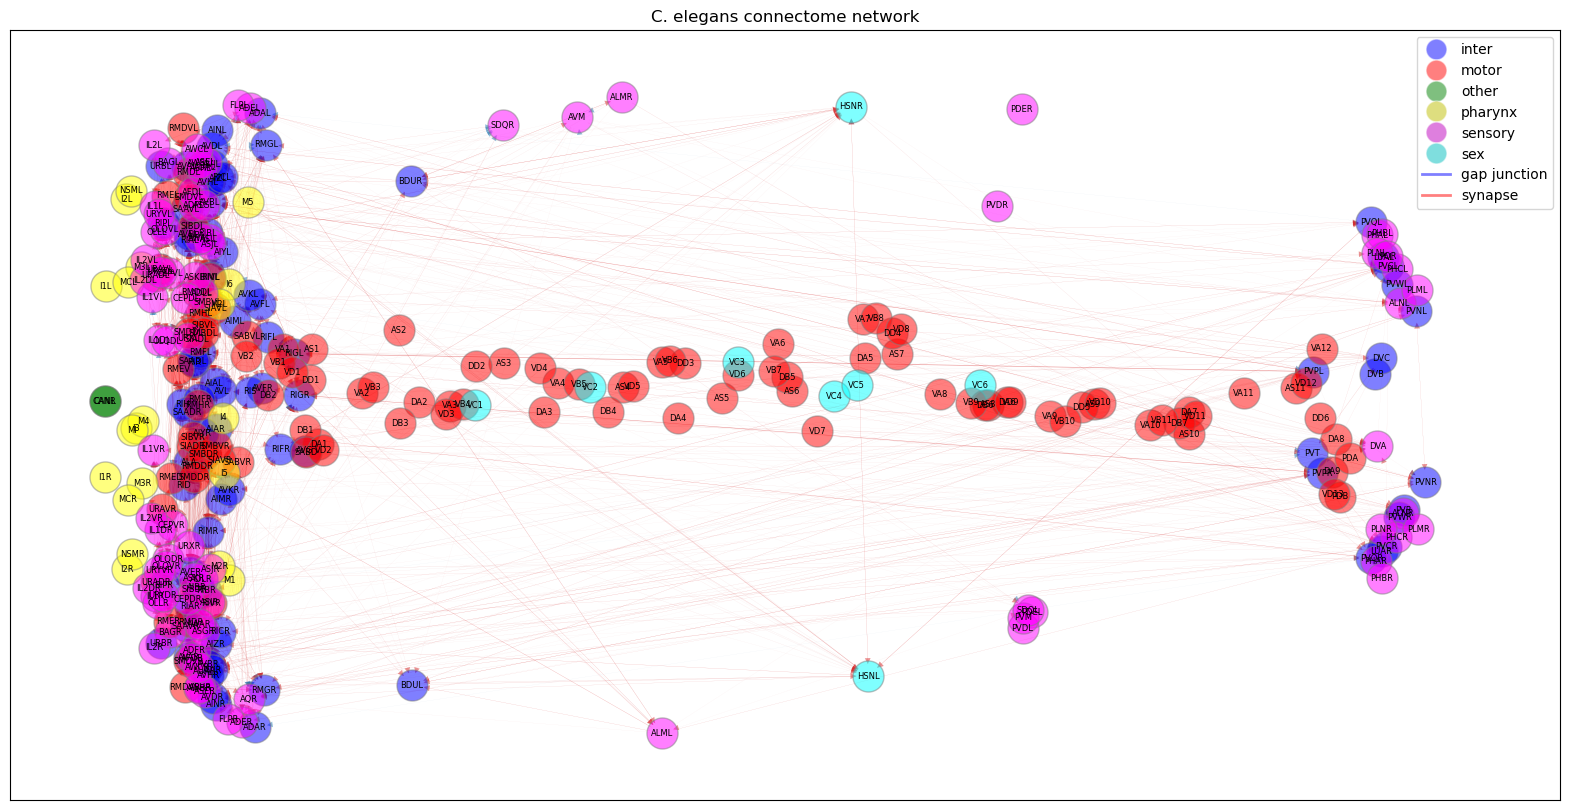

In [10]:
df = pd.read_csv("../data/raw/white_1986_n2u_processed.csv")
origin = []
target = []
edges = []

NEURON_LABELS = [ # TODO: Cite source of this list.
            "ADAL", "ADAR", "ADEL", "ADER", "ADFL", "ADFR", "ADLL", "ADLR", "AFDL", "AFDR",
            "AIAL", "AIAR", "AIBL", "AIBR", "AIML", "AIMR", "AINL", "AINR", "AIYL", "AIYR",
            "AIZL", "AIZR", "ALA", "ALML", "ALMR", "ALNL", "ALNR", "AQR", "AS1", "AS10",
            "AS11", "AS2", "AS3", "AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "ASEL", "ASER",
            "ASGL", "ASGR", "ASHL", "ASHR", "ASIL", "ASIR", "ASJL", "ASJR", "ASKL", "ASKR",
            "AUAL", "AUAR", "AVAL", "AVAR", "AVBL", "AVBR", "AVDL", "AVDR", "AVEL", "AVER",
            "AVFL", "AVFR", "AVG", "AVHL", "AVHR", "AVJL", "AVJR", "AVKL", "AVKR", "AVL",
            "AVM", "AWAL", "AWAR", "AWBL", "AWBR", "AWCL", "AWCR", "BAGL", "BAGR", "BDUL",
            "BDUR", "CANL", "CANR", "CEPDL", "CEPDR", "CEPVL", "CEPVR", "DA1", "DA2", "DA3",
            "DA4", "DA5", "DA6", "DA7", "DA8", "DA9", "DB1", "DB2", "DB3", "DB4", "DB5",
            "DB6", "DB7", "DD1", "DD2", "DD3", "DD4", "DD5", "DD6", "DVA", "DVB", "DVC",
            "FLPL", "FLPR", "HSNL", "HSNR", "I1L", "I1R", "I2L", "I2R", "I3", "I4", "I5",
            "I6", "IL1DL", "IL1DR", "IL1L", "IL1R", "IL1VL", "IL1VR", "IL2DL", "IL2DR", "IL2L",
            "IL2R", "IL2VL", "IL2VR", "LUAL", "LUAR", "M1", "M2L", "M2R", "M3L", "M3R", "M4",
            "M5", "MCL", "MCR", "MI", "NSML", "NSMR", "OLLL", "OLLR", "OLQDL", "OLQDR",
            "OLQVL", "OLQVR", "PDA", "PDB", "PDEL", "PDER", "PHAL", "PHAR", "PHBL", "PHBR",
            "PHCL", "PHCR", "PLML", "PLMR", "PLNL", "PLNR", "PQR", "PVCL", "PVCR", "PVDL",
            "PVDR", "PVM", "PVNL", "PVNR", "PVPL", "PVPR", "PVQL", "PVQR", "PVR", "PVT",
            "PVWL", "PVWR", "RIAL", "RIAR", "RIBL", "RIBR", "RICL", "RICR", "RID", "RIFL",
            "RIFR", "RIGL", "RIGR", "RIH", "RIML", "RIMR", "RIPL", "RIPR", "RIR", "RIS",
            "RIVL", "RIVR", "RMDDL", "RMDDR", "RMDL", "RMDR", "RMDVL", "RMDVR", "RMED",
            "RMEL", "RMER", "RMEV", "RMFL", "RMFR", "RMGL", "RMGR", "RMHL", "RMHR", "SAADL",
            "SAADR", "SAAVL", "SAAVR", "SABD", "SABVL", "SABVR", "SDQL", "SDQR", "SIADL",
            "SIADR", "SIAVL", "SIAVR", "SIBDL", "SIBDR", "SIBVL", "SIBVR", "SMBDL", "SMBDR",
            "SMBVL", "SMBVR", "SMDDL", "SMDDR", "SMDVL", "SMDVR", "URADL", "URADR", "URAVL",
            "URAVR", "URBL", "URBR", "URXL", "URXR", "URYDL", "URYDR", "URYVL", "URYVR",
            "VA1", "VA10", "VA11", "VA12", "VA2", "VA3", "VA4", "VA5", "VA6", "VA7", "VA8",
            "VA9", "VB1", "VB10", "VB11", "VB2", "VB3", "VB4", "VB5", "VB6", "VB7", "VB8",
            "VB9", "VC1", "VC2", "VC3", "VC4", "VC5", "VC6", "VD1", "VD10", "VD11", "VD12",
            "VD13", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9"
        ]

edge_attr = []

for i in range(len(df)):
    neuron1 = df.loc[i, "pre"]
    neuron2 = df.loc[i, "post"]
    
    if neuron1 in NEURON_LABELS and neuron2 in NEURON_LABELS:
        origin += [neuron1]
        target += [neuron2]
        
        type = df.loc[i, "type"]
        num_connections = df.loc[i, "synapses"]
        
        if [neuron1, neuron2] not in edges:
            edges += [[neuron1, neuron2]]
            if type == "electrical":
                edge_attr += [[num_connections, 0]]
            else:
                edge_attr += [[0, num_connections]]
        else:
            if type == "electrical":
                edge_attr[-1][0] = num_connections
            else:
                edge_attr[-1][-1] = num_connections

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "white_1986_n2u_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)

# White 1986 jsh

Attributes: 
 <bound method BaseData.keys of Data(
  x=[302, 1024],
  edge_index=[2, 1533],
  edge_attr=[1533, 2],
  y=[302],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2],
    7=[2],
    8=[2],
    9=[2],
    10=[2],
    11=[2],
    12=[2],
    13=[2],
    14=[2],
    15=[2],
    16=[2],
    17=[2],
    18=[2],
    19=[2],
    20=[2],
    21=[2],
    22=[2],
    23=[2],
    24=[2],
    25=[2],
    26=[2],
    27=[2],
    28=[2],
    29=[2],
    30=[2],
    31=[2],
    32=[2],
    33=[2],
    34=[2],
    35=[2],
    36=[2],
    37=[2],
    38=[2],
    39=[2],
    40=[2],
    41=[2],
    42=[2],
    43=[2],
    44=[2],
    45=[2],
    46=[2],
    47=[2],
    48=[2],
    49=[2],
    50=[2],
    51=[2],
    52=[2],
    53=[2],
    54=[2],
    55=[2],
    56=[2],
    57=[2],
    58=[2],
    59=[2],
    60=[2],
    61=[2],
    62=[2],
    63=[2],
    64=[2],
    65=[2],
    66=[2],
    67=[2],
    68=[2],
    69=[2],
    70=[2],
    71=[2],
    72=[2],


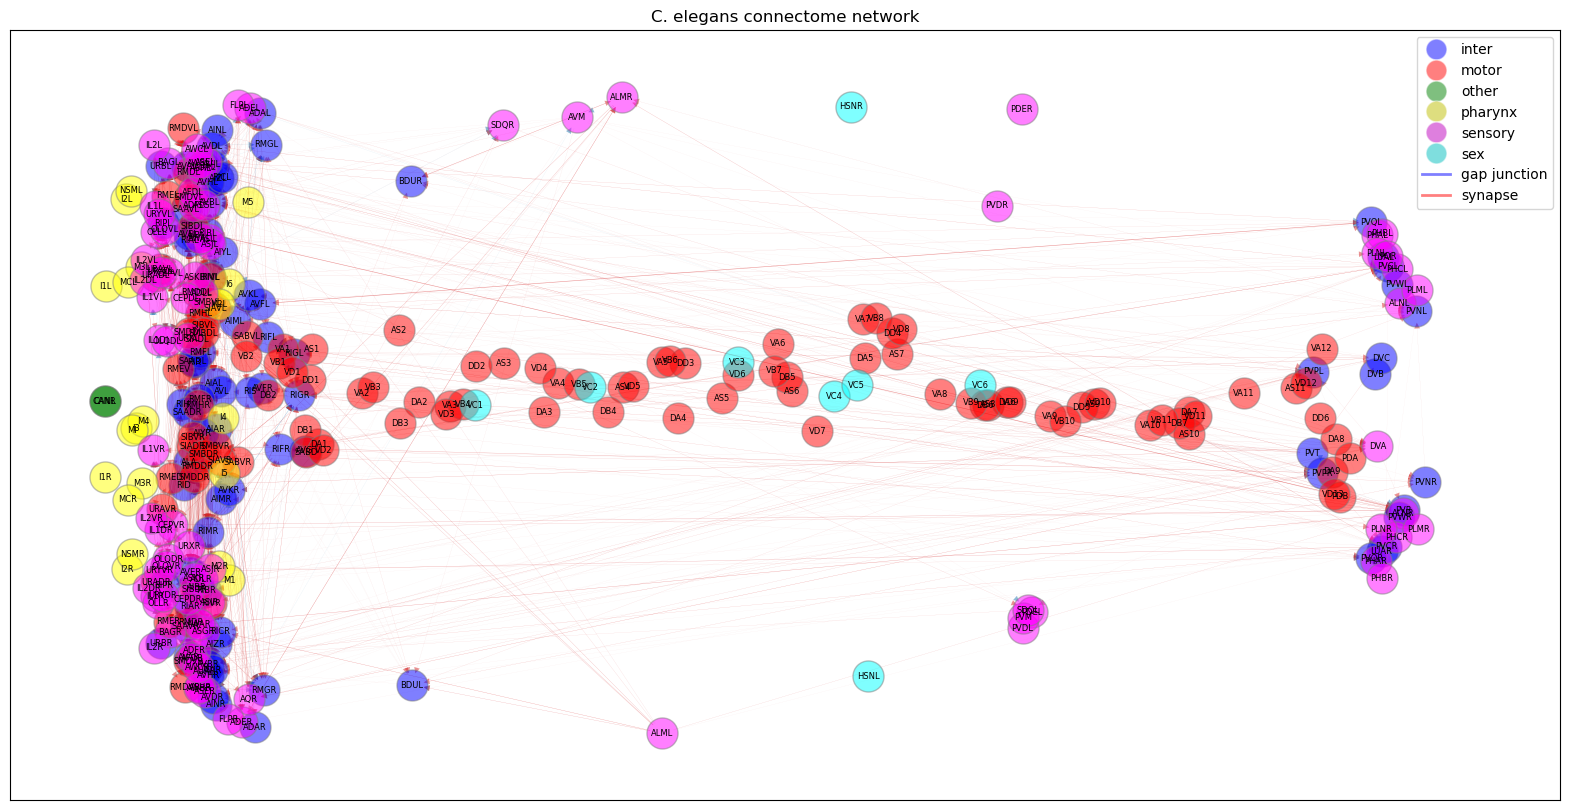

In [12]:
df = pd.read_csv("../data/raw/white_1986_jsh_processed.csv")
origin = []
target = []
edges = []

NEURON_LABELS = [ # TODO: Cite source of this list.
            "ADAL", "ADAR", "ADEL", "ADER", "ADFL", "ADFR", "ADLL", "ADLR", "AFDL", "AFDR",
            "AIAL", "AIAR", "AIBL", "AIBR", "AIML", "AIMR", "AINL", "AINR", "AIYL", "AIYR",
            "AIZL", "AIZR", "ALA", "ALML", "ALMR", "ALNL", "ALNR", "AQR", "AS1", "AS10",
            "AS11", "AS2", "AS3", "AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "ASEL", "ASER",
            "ASGL", "ASGR", "ASHL", "ASHR", "ASIL", "ASIR", "ASJL", "ASJR", "ASKL", "ASKR",
            "AUAL", "AUAR", "AVAL", "AVAR", "AVBL", "AVBR", "AVDL", "AVDR", "AVEL", "AVER",
            "AVFL", "AVFR", "AVG", "AVHL", "AVHR", "AVJL", "AVJR", "AVKL", "AVKR", "AVL",
            "AVM", "AWAL", "AWAR", "AWBL", "AWBR", "AWCL", "AWCR", "BAGL", "BAGR", "BDUL",
            "BDUR", "CANL", "CANR", "CEPDL", "CEPDR", "CEPVL", "CEPVR", "DA1", "DA2", "DA3",
            "DA4", "DA5", "DA6", "DA7", "DA8", "DA9", "DB1", "DB2", "DB3", "DB4", "DB5",
            "DB6", "DB7", "DD1", "DD2", "DD3", "DD4", "DD5", "DD6", "DVA", "DVB", "DVC",
            "FLPL", "FLPR", "HSNL", "HSNR", "I1L", "I1R", "I2L", "I2R", "I3", "I4", "I5",
            "I6", "IL1DL", "IL1DR", "IL1L", "IL1R", "IL1VL", "IL1VR", "IL2DL", "IL2DR", "IL2L",
            "IL2R", "IL2VL", "IL2VR", "LUAL", "LUAR", "M1", "M2L", "M2R", "M3L", "M3R", "M4",
            "M5", "MCL", "MCR", "MI", "NSML", "NSMR", "OLLL", "OLLR", "OLQDL", "OLQDR",
            "OLQVL", "OLQVR", "PDA", "PDB", "PDEL", "PDER", "PHAL", "PHAR", "PHBL", "PHBR",
            "PHCL", "PHCR", "PLML", "PLMR", "PLNL", "PLNR", "PQR", "PVCL", "PVCR", "PVDL",
            "PVDR", "PVM", "PVNL", "PVNR", "PVPL", "PVPR", "PVQL", "PVQR", "PVR", "PVT",
            "PVWL", "PVWR", "RIAL", "RIAR", "RIBL", "RIBR", "RICL", "RICR", "RID", "RIFL",
            "RIFR", "RIGL", "RIGR", "RIH", "RIML", "RIMR", "RIPL", "RIPR", "RIR", "RIS",
            "RIVL", "RIVR", "RMDDL", "RMDDR", "RMDL", "RMDR", "RMDVL", "RMDVR", "RMED",
            "RMEL", "RMER", "RMEV", "RMFL", "RMFR", "RMGL", "RMGR", "RMHL", "RMHR", "SAADL",
            "SAADR", "SAAVL", "SAAVR", "SABD", "SABVL", "SABVR", "SDQL", "SDQR", "SIADL",
            "SIADR", "SIAVL", "SIAVR", "SIBDL", "SIBDR", "SIBVL", "SIBVR", "SMBDL", "SMBDR",
            "SMBVL", "SMBVR", "SMDDL", "SMDDR", "SMDVL", "SMDVR", "URADL", "URADR", "URAVL",
            "URAVR", "URBL", "URBR", "URXL", "URXR", "URYDL", "URYDR", "URYVL", "URYVR",
            "VA1", "VA10", "VA11", "VA12", "VA2", "VA3", "VA4", "VA5", "VA6", "VA7", "VA8",
            "VA9", "VB1", "VB10", "VB11", "VB2", "VB3", "VB4", "VB5", "VB6", "VB7", "VB8",
            "VB9", "VC1", "VC2", "VC3", "VC4", "VC5", "VC6", "VD1", "VD10", "VD11", "VD12",
            "VD13", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9"
        ]

edge_attr = []

for i in range(len(df)):
    neuron1 = df.loc[i, "pre"]
    neuron2 = df.loc[i, "post"]
    
    if neuron1 in NEURON_LABELS and neuron2 in NEURON_LABELS:
        origin += [neuron1]
        target += [neuron2]
        
        type = df.loc[i, "type"]
        num_connections = df.loc[i, "synapses"]
        
        if [neuron1, neuron2] not in edges:
            edges += [[neuron1, neuron2]]
            if type == "electrical":
                edge_attr += [[num_connections, 0]]
            else:
                edge_attr += [[0, num_connections]]
        else:
            if type == "electrical":
                edge_attr[-1][0] = num_connections
            else:
                edge_attr[-1][-1] = num_connections

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "white_1986_jsh_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)

# White 1986 jse

Attributes: 
 <bound method BaseData.keys of Data(
  x=[302, 1024],
  edge_index=[2, 94],
  edge_attr=[94, 2],
  y=[302],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2],
    7=[2],
    8=[2],
    9=[2],
    10=[2],
    11=[2],
    12=[2],
    13=[2],
    14=[2],
    15=[2],
    16=[2],
    17=[2],
    18=[2],
    19=[2],
    20=[2],
    21=[2],
    22=[2],
    23=[2],
    24=[2],
    25=[2],
    26=[2],
    27=[2],
    28=[2],
    29=[2],
    30=[2],
    31=[2],
    32=[2],
    33=[2],
    34=[2],
    35=[2],
    36=[2],
    37=[2],
    38=[2],
    39=[2],
    40=[2],
    41=[2],
    42=[2],
    43=[2],
    44=[2],
    45=[2],
    46=[2],
    47=[2],
    48=[2],
    49=[2],
    50=[2],
    51=[2],
    52=[2],
    53=[2],
    54=[2],
    55=[2],
    56=[2],
    57=[2],
    58=[2],
    59=[2],
    60=[2],
    61=[2],
    62=[2],
    63=[2],
    64=[2],
    65=[2],
    66=[2],
    67=[2],
    68=[2],
    69=[2],
    70=[2],
    71=[2],
    72=[2],
    

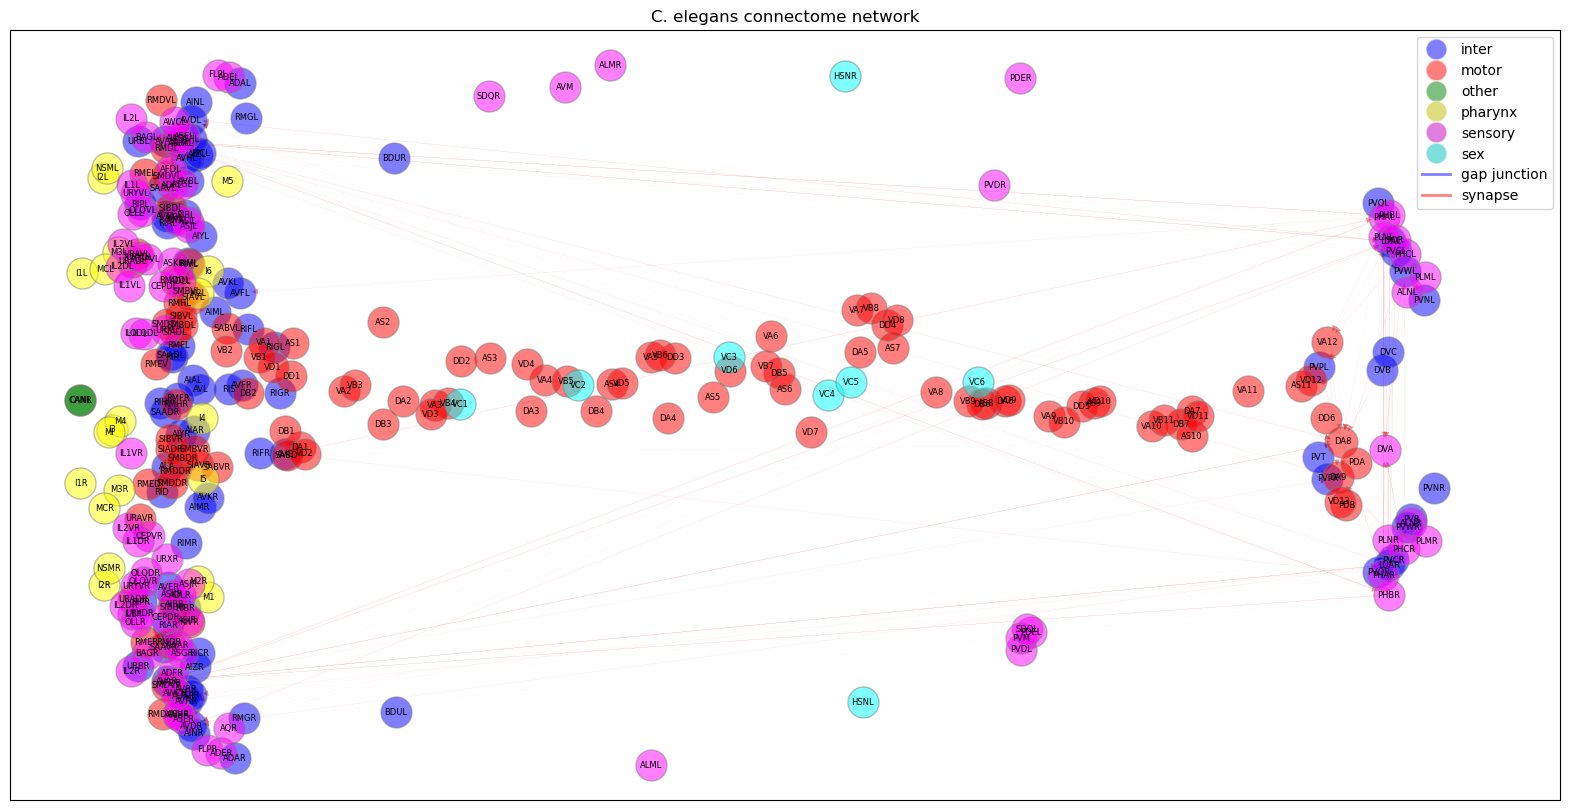

In [16]:
df = pd.read_csv("../data/raw/white_1986_jse_processed.csv")
origin = []
target = []
edges = []

NEURON_LABELS = [ # TODO: Cite source of this list.
            "ADAL", "ADAR", "ADEL", "ADER", "ADFL", "ADFR", "ADLL", "ADLR", "AFDL", "AFDR",
            "AIAL", "AIAR", "AIBL", "AIBR", "AIML", "AIMR", "AINL", "AINR", "AIYL", "AIYR",
            "AIZL", "AIZR", "ALA", "ALML", "ALMR", "ALNL", "ALNR", "AQR", "AS1", "AS10",
            "AS11", "AS2", "AS3", "AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "ASEL", "ASER",
            "ASGL", "ASGR", "ASHL", "ASHR", "ASIL", "ASIR", "ASJL", "ASJR", "ASKL", "ASKR",
            "AUAL", "AUAR", "AVAL", "AVAR", "AVBL", "AVBR", "AVDL", "AVDR", "AVEL", "AVER",
            "AVFL", "AVFR", "AVG", "AVHL", "AVHR", "AVJL", "AVJR", "AVKL", "AVKR", "AVL",
            "AVM", "AWAL", "AWAR", "AWBL", "AWBR", "AWCL", "AWCR", "BAGL", "BAGR", "BDUL",
            "BDUR", "CANL", "CANR", "CEPDL", "CEPDR", "CEPVL", "CEPVR", "DA1", "DA2", "DA3",
            "DA4", "DA5", "DA6", "DA7", "DA8", "DA9", "DB1", "DB2", "DB3", "DB4", "DB5",
            "DB6", "DB7", "DD1", "DD2", "DD3", "DD4", "DD5", "DD6", "DVA", "DVB", "DVC",
            "FLPL", "FLPR", "HSNL", "HSNR", "I1L", "I1R", "I2L", "I2R", "I3", "I4", "I5",
            "I6", "IL1DL", "IL1DR", "IL1L", "IL1R", "IL1VL", "IL1VR", "IL2DL", "IL2DR", "IL2L",
            "IL2R", "IL2VL", "IL2VR", "LUAL", "LUAR", "M1", "M2L", "M2R", "M3L", "M3R", "M4",
            "M5", "MCL", "MCR", "MI", "NSML", "NSMR", "OLLL", "OLLR", "OLQDL", "OLQDR",
            "OLQVL", "OLQVR", "PDA", "PDB", "PDEL", "PDER", "PHAL", "PHAR", "PHBL", "PHBR",
            "PHCL", "PHCR", "PLML", "PLMR", "PLNL", "PLNR", "PQR", "PVCL", "PVCR", "PVDL",
            "PVDR", "PVM", "PVNL", "PVNR", "PVPL", "PVPR", "PVQL", "PVQR", "PVR", "PVT",
            "PVWL", "PVWR", "RIAL", "RIAR", "RIBL", "RIBR", "RICL", "RICR", "RID", "RIFL",
            "RIFR", "RIGL", "RIGR", "RIH", "RIML", "RIMR", "RIPL", "RIPR", "RIR", "RIS",
            "RIVL", "RIVR", "RMDDL", "RMDDR", "RMDL", "RMDR", "RMDVL", "RMDVR", "RMED",
            "RMEL", "RMER", "RMEV", "RMFL", "RMFR", "RMGL", "RMGR", "RMHL", "RMHR", "SAADL",
            "SAADR", "SAAVL", "SAAVR", "SABD", "SABVL", "SABVR", "SDQL", "SDQR", "SIADL",
            "SIADR", "SIAVL", "SIAVR", "SIBDL", "SIBDR", "SIBVL", "SIBVR", "SMBDL", "SMBDR",
            "SMBVL", "SMBVR", "SMDDL", "SMDDR", "SMDVL", "SMDVR", "URADL", "URADR", "URAVL",
            "URAVR", "URBL", "URBR", "URXL", "URXR", "URYDL", "URYDR", "URYVL", "URYVR",
            "VA1", "VA10", "VA11", "VA12", "VA2", "VA3", "VA4", "VA5", "VA6", "VA7", "VA8",
            "VA9", "VB1", "VB10", "VB11", "VB2", "VB3", "VB4", "VB5", "VB6", "VB7", "VB8",
            "VB9", "VC1", "VC2", "VC3", "VC4", "VC5", "VC6", "VD1", "VD10", "VD11", "VD12",
            "VD13", "VD2", "VD3", "VD4", "VD5", "VD6", "VD7", "VD8", "VD9"
        ]

edge_attr = []

for i in range(len(df)):
    neuron1 = df.loc[i, "pre"]
    neuron2 = df.loc[i, "post"]
    
    if neuron1 in NEURON_LABELS and neuron2 in NEURON_LABELS:
        origin += [neuron1]
        target += [neuron2]
        
        type = df.loc[i, "type"]
        num_connections = df.loc[i, "synapses"]
        
        if [neuron1, neuron2] not in edges:
            edges += [[neuron1, neuron2]]
            if type == "electrical":
                edge_attr += [[num_connections, 0]]
            else:
                edge_attr += [[0, num_connections]]
        else:
            if type == "electrical":
                edge_attr[-1][0] = num_connections
            else:
                edge_attr[-1][-1] = num_connections

neuron_to_idx = dict(zip(NEURON_LABELS, [i for i in range(len(NEURON_LABELS))]))
idx_to_neuron = dict(zip([i for i in range(len(NEURON_LABELS))], NEURON_LABELS))

edge_index = torch.tensor([[neuron_to_idx[neuron1], neuron_to_idx[neuron2]] for neuron1, neuron2 in edges]).T
node_type = {0: 'Type1', 1: 'Type2'}
num_classes = len(node_type)
n_id = torch.tensor([i for i in range(len(NEURON_LABELS))])

# for x, y values
# Neurons involved in chemical synapses
GHermChem_Nodes = pd.read_csv("../data/raw/GHermChem_Nodes.csv")  # nodes
neurons_all = set(NEURON_LABELS)

df = GHermChem_Nodes
df["Name"] = [v.replace("0", "") if not v.endswith("0") else v for v in df["Name"]]
Gsyn_nodes = df[df["Name"].isin(neurons_all)].sort_values(by=["Name"]).reset_index()

le = preprocessing.LabelEncoder()
le.fit(Gsyn_nodes.Group.values)
# num_classes = len(le.classes_)
y = torch.tensor(le.transform(Gsyn_nodes.Group.values), dtype=torch.int32)
x = torch.randn(len(NEURON_LABELS), 1024, dtype=torch.float)

temp_graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# pos = dict(zip([i for i in range(len(NEURON_LABELS))], [np.random.randn(2) for i in range(len(NEURON_LABELS))]))
pos = temp_graph_tensors["pos"]
edge_attr = torch.tensor(edge_attr)

graph_tensors = {
    "edge_index": edge_index,
    "edge_attr": edge_attr,
    "pos": pos,
    "num_classes": num_classes,
    "x": x,
    "y": y,
    "idx_to_neuron": idx_to_neuron,
    "node_type": node_type,
    "n_id": n_id,
}

torch.save(
    graph_tensors,
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "white_1986_jse_graph_tensors.pt"),
)

# make the graph
graph = Data(**graph_tensors)

# investigate the graph
print(
    "Attributes:",
    "\n",
    graph.keys,
    "\n",
    f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, "
    f"Num. node features {graph.num_node_features}",
    end="\n",
)
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}")

# draw the connectome
draw_connectome(graph)